In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from importHelpers.response import *
from mlxtend.preprocessing import minmax_scaling
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#### clean

In [2]:
xls = pd.ExcelFile(r'data\\191126P2_ROIAnnotationSummary_200218.xlsx')
df = pd.read_excel(xls, 'Annotation_Summary')
df = df[['Flash', '2P ROI', 'RBPMS', 'Syt10+', 'Syt6+', 'CAVIII', 'ChAT', 'Satb2', 'MEIS', 'CalR']]
df = df.dropna(axis = 0, subset = ["2P ROI"])
df = df[df['2P ROI'].apply(lambda x: str(x).isdigit())]
df = df.astype({"2P ROI": int})
for col in ['Syt10+', 'Syt6+', 'CAVIII', 'ChAT', 'Satb2', 'MEIS', 'CalR']:
    df[col] = df[col].apply(lambda x: int(not pd.isna(x)))

In [3]:
l = list(df.T)
def name_merge(x):
    p = [str(i[l[x]]) for _, i in df.loc[[l[x]]].to_dict().items()]
    return p[0] + '_wave_' + str(p[1])
name_merge(0)

def uniquer(x):
    return "".join([str(i[l[x]]) for _, i in df.loc[[l[x]]].to_dict().items()][2:])

d = {}
c = 0
z = []
for i in range(df.shape[0]):
    u = uniquer(i)
    if u not in d.keys():
        d[u] = c
        c += 1
    z.append(d[u])
df.insert(10, "Class", z)

s = []
for i in range(df.shape[0]):
    s.append(name_merge(i))

#### combine

In [4]:
# FILENAME
xlsx_filename = "data\\191126P2PhysData_withlabels.xlsx"
excel = pd.ExcelFile(xlsx_filename)

def renamer(sheet, ind):
    l = lambda name: str(ind) + '_' + name
    sheet = sheet.rename(index = l)
    return sheet
i = 0
new_sheetnames = ['Flash_40', 'Flash_52', 'Flash_56', 'Flash_58', 'Flash_60', 'Flash_66', 'Flash_68', 'Flash_46']
total = renamer(pd.read_excel(xlsx_filename,sheet_name=excel.sheet_names[i], header=0).T, new_sheetnames[0])
for i in range(1, len(excel.sheet_names)):
    print('Working on sheet ' + str(i + 1) + ' of ' + str(len(excel.sheet_names)))
    total = total.append(renamer(pd.read_excel(xlsx_filename,sheet_name=excel.sheet_names[i], header=0).T, new_sheetnames[i]))
print("Sheet combination complete.")
n = total

Working on sheet 2 of 8
Working on sheet 3 of 8
Working on sheet 4 of 8
Working on sheet 5 of 8
Working on sheet 6 of 8
Working on sheet 7 of 8
Working on sheet 8 of 8
Sheet combination complete.


In [5]:
n = n[[i in s for i in n.index]]
n

0         1         2         3         4         5    \
Flash_40_wave_1  -0.282811  0.832223  1.571895  1.511685  1.777528  2.218740   
Flash_40_wave_2   0.571081  0.494429  0.751718  0.580546  0.632446  0.855266   
Flash_40_wave_3   2.096727  3.333588  3.859820  4.164157  4.005630  4.153227   
Flash_40_wave_4   0.281441  0.346466  0.693288  0.877922  0.841007  0.955635   
Flash_40_wave_5   0.578530  1.201865  1.635306  1.709711  1.883825  1.952654   
...                    ...       ...       ...       ...       ...       ...   
Flash_46_wave_59  3.514678  4.924971  5.835104  6.257974  6.559562  6.262323   
Flash_46_wave_65  2.334159  2.937608  2.372215  2.007245  1.645733  1.116064   
Flash_46_wave_76  5.914798  7.498043  7.846637  7.547990  7.341963  7.228784   
Flash_46_wave_86  0.569609  1.132857  1.210412  1.188244  1.100053  1.046596   
Flash_46_wave_94 -0.372969 -0.393594  0.042007 -0.065661 -0.007022 -0.026779   

                       6         7         8         9    ...       190  \
Flash_40_wave_1   2.128655  1.977111  2.087082  2.107779  ...  2.047339   
Flash_40_wave_2   0.680370  0.764025  0.453674  0.620698  ...  0.516698   
Flash_40_wave_3   4.078456  3.821792  3.855679  3.537391  ...  4.618674   
Flash_40_wave_4   1.120212  1.092848  1.156230  1.256585  ...  1.031648   
Flash_40_wave_5   1.961918  2.008558  1.999788  2.141422  ...  1.150016   
...                    ...       ...       ...       ...  ...       ...   
Flash_46_wave_59  6.273296  6.150227  6.417154  6.272162  ...  4.959475   
Flash_46_wave_65  0.814676  1.469086  1.106885  1.502549  ...  0.952743   
Flash_46_wave_76  7.064824  7.246309  7.724882  7.847785  ...  5.629679   
Flash_46_wave_86  0.846080  0.704067  0.861538  0.743415  ...  0.876272   
Flash_46_wave_94 -0.182787 -0.428858 -0.207789 -0.179428  ... -0.550326   

                       191       192       193       194       195       196  \
Flash_40_wave_1   2.123366  1.872845  2.199981  2.028838  2.053396  2.005515   
Flash_40_wave_2   0.785411  0.556864  0.525525  0.621531  0.685788  0.578357   
Flash_40_wave_3   4.476266  4.738743  4.588993  4.546078  4.538284  4.452612   
Flash_40_wave_4   0.785741  0.998500  0.974495  0.936173  0.851405  0.943852   
Flash_40_wave_5   0.960056  1.104510  0.978815  0.958205  0.997115  1.030643   
...                    ...       ...       ...       ...       ...       ...   
Flash_46_wave_59  5.125802  5.191646  5.029380  5.086942  5.264967  5.195457   
Flash_46_wave_65  0.747290  0.905035  0.744348  0.933812  0.672914  0.545547   
Flash_46_wave_76  5.542924  5.973587  5.648575  5.370740  5.610396  5.612535   
Flash_46_wave_86  1.013606  1.181771  1.193820  0.839227  0.850917  0.906549   
Flash_46_wave_94 -0.428076 -0.298865 -0.432138 -0.396407 -0.661898 -0.674112   

                       197       198       199  
Flash_40_wave_1   2.070698  1.913456  1.785120  
Flash_40_wave_2   0.565160  0.614412  0.469929  
Flash_40_wave_3   4.481684  4.693524  4.886218  
Flash_40_wave_4   0.935190  0.879609  0.934099  
Flash_40_wave_5   1.107826  0.940766  1.002950  
...                    ...       ...       ...  
Flash_46_wave_59  5.340018  5.472021  5.607791  
Flash_46_wave_65  0.528410  0.571942  0.361723  
Flash_46_wave_76  5.962801  5.818900  5.763261  
Flash_46_wave_86  0.899229  1.125085  1.173561  
Flash_46_wave_94 -0.378286 -0.261541 -0.623124  

[603 rows x 200 columns]

In [6]:
list(n.index)

['Flash_40_wave_1',
 'Flash_40_wave_2',
 'Flash_40_wave_3',
 'Flash_40_wave_4',
 'Flash_40_wave_5',
 'Flash_40_wave_6',
 'Flash_40_wave_7',
 'Flash_40_wave_8',
 'Flash_40_wave_9',
 'Flash_40_wave_10',
 'Flash_40_wave_11',
 'Flash_40_wave_12',
 'Flash_40_wave_13',
 'Flash_40_wave_14',
 'Flash_40_wave_15',
 'Flash_40_wave_16',
 'Flash_40_wave_17',
 'Flash_40_wave_18',
 'Flash_40_wave_19',
 'Flash_40_wave_20',
 'Flash_40_wave_21',
 'Flash_40_wave_22',
 'Flash_40_wave_23',
 'Flash_40_wave_24',
 'Flash_40_wave_25',
 'Flash_40_wave_26',
 'Flash_40_wave_27',
 'Flash_40_wave_28',
 'Flash_40_wave_29',
 'Flash_40_wave_30',
 'Flash_40_wave_31',
 'Flash_40_wave_32',
 'Flash_40_wave_33',
 'Flash_40_wave_34',
 'Flash_40_wave_35',
 'Flash_40_wave_37',
 'Flash_40_wave_38',
 'Flash_40_wave_39',
 'Flash_40_wave_40',
 'Flash_40_wave_41',
 'Flash_40_wave_42',
 'Flash_40_wave_43',
 'Flash_40_wave_44',
 'Flash_40_wave_45',
 'Flash_40_wave_46',
 'Flash_40_wave_47',
 'Flash_40_wave_48',
 'Flash_40_wave_49',
 

In [7]:
def getClassByName(name):
    return z[s.index(name)]

In [8]:
n_class = []
for name in list(n.index):
    n_class.append(getClassByName(name))

In [9]:
len(n_class)

603

In [10]:
def transform(initial):
    # remove and subtract baseline
    # c = frameToSecDF(initial.sub(initial['baseline'], axis = 'rows').drop('baseline', axis = 1).T)
    # drop 70
    c = initial
    a = [a - b > 70 for a, b in zip(list(c.max(axis = 1)), list(c.min(axis= 0)))]
    dropped = []
    for i in range(len(a)):
        if not a[i]:
            dropped.append(list(c.T)[i])
    c = c.drop(dropped, axis = 0)
    # -1 1 scale
    last = c[c.columns[-15:]]
    last = last.mean(axis=1)
    ne = c.sub(last, axis = 0)
    n_one = ne.div(ne.abs().max(axis = 1), axis = 0)
    return n_one

In [11]:
#n = df
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(n)
principalDf = pd.DataFrame(data = principalComponents)
pca_n = pd.DataFrame(data = pca.inverse_transform(principalComponents))
pca_n = pca_n.rename(index={a:b for a,b in zip(range(len(list(n.T))),list(n.T))}, columns={a:b for a,b in zip(range(len(list(n))),list(n))})
# comment next line for no PCA
next_n = pca_n

In [12]:
db = DBSCAN(eps=3, min_samples=2).fit(next_n)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
dlabels = db.labels_
print("DBSCAN with your params found:")
print(str(max(dlabels + 1)) + " classified labels")
print(str(list(dlabels).count(-1)) + ' unclassified points out of ' + str(len(dlabels)))

DBSCAN with your params found:
21 classified labels
107 unclassified points out of 603


In [13]:
#n.insert(200, "Class", n_class)

In [14]:
dlabels

array([-1,  0, -1,  1,  0, -1,  2, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  3,  0,  4,
       -1,  0,  0, -1,  0, -1,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  5,  0, -1,  0,  0,  6, -1,  0, -1, -1,  0, -1,  0,  7,  5, -1,
        0,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  8,  6,
        0, -1,  9,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
        0,  0, -1, 11, -1, -1, -1, 12, -1, -1, -1, -1, -1, 13, -1, 13, -1,
       -1,  0,  0,  0,  0,  0,  0, 14,  0, -1, -1,  0,  0,  0,  0, 15,  0,
       -1,  0,  0,  0,  0, 16,  0,  0,  0,  0, -1,  0,  1,  0, -1, -1,  0,
        0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0, 16,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0, -1,  0,  0

In [15]:
n_class

[2,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 2,
 3,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 4,
 2,
 1,
 1,
 4,
 1,
 11,
 1,
 0,
 1,
 1,
 7,
 4,
 1,
 3,
 2,
 8,
 1,
 1,
 1,
 11,
 1,
 1,
 12,
 1,
 1,
 10,
 3,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 3,
 1,
 5,
 6,
 1,
 1,
 1,
 1,
 1,
 3,
 10,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 9,
 0,
 10,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 2,
 5,
 1,
 5,
 1,
 10,
 1,
 1,
 1,
 1,
 1,
 10,
 1,
 4,
 0,
 1,
 5,
 4,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 9,
 1,
 4,
 0,
 4,
 1,
 4,
 1,
 1,
 5,
 1,
 5,
 4,
 2,
 1,
 10,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 3,
 1,
 4,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 13,
 2,
 0,
 1,
 0,
 1,
 1,
 13,
 14,
 10,
 1,
 1,
 1,
 1,
 1,
 1,
 10,
 4,
 9,
 2,
 5,
 1,
 1,
 10,
 1,
 1,
 1,
 1,
 10,
 1,
 1,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 10,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 5,
 1,
 0,
 0,
 1,

In [16]:
def accuracy(dlabels, n_class):    
    correct = 0
    total = 0
    for i in range(len(n_class)):
        for j in range(i + 1, len(n_class)):
            if (dlabels[i] == -1):
                continue
            if (dlabels[i] == dlabels[j]):
                if (n_class[i] == n_class[j]):
                    correct += 1
                total += 1
    return correct, total

In [17]:
c, t = accuracy(dlabels, n_class)

In [18]:
c/t

0.4419373945306825

In [28]:
lots_of_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff'] * 2

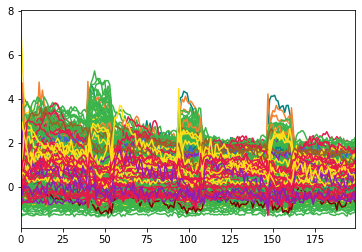

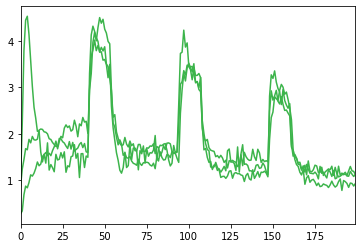

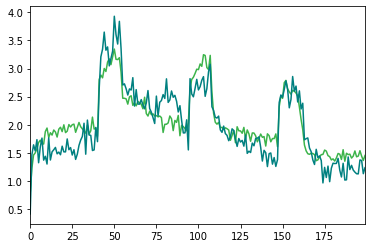

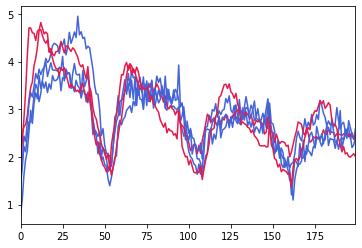

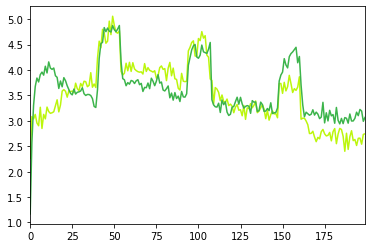

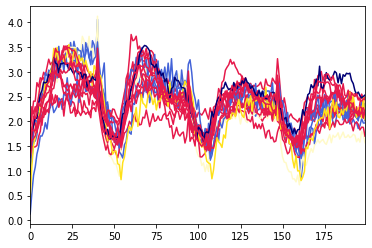

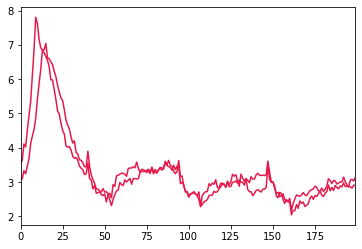

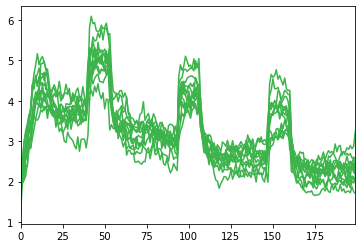

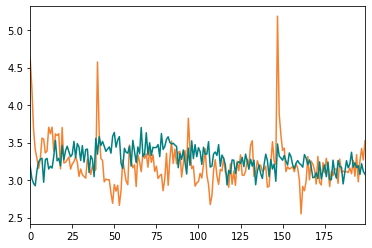

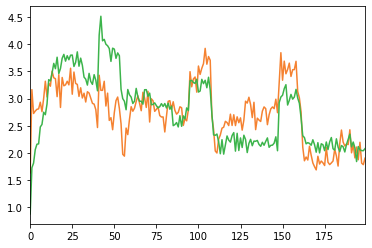

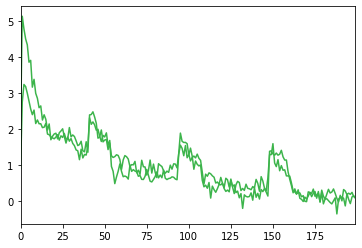

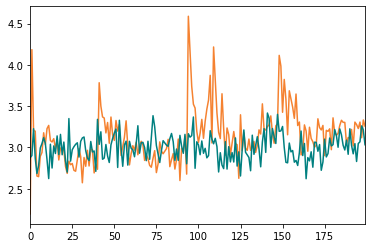

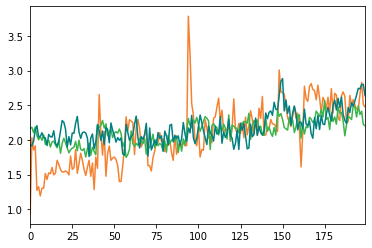

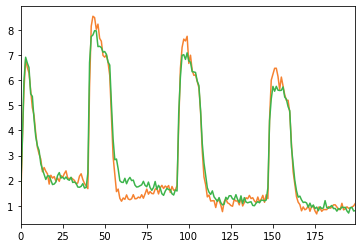

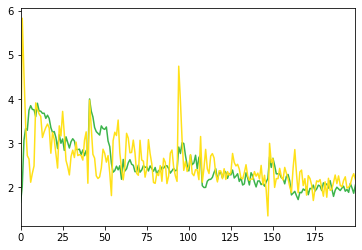

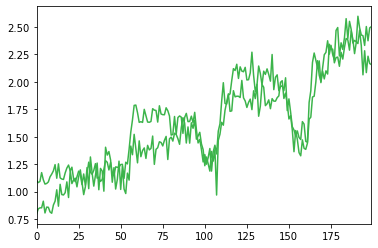

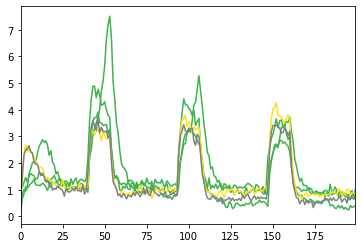

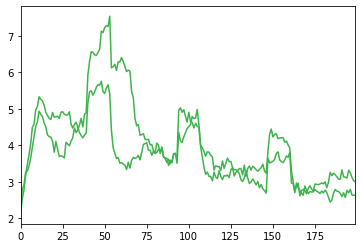

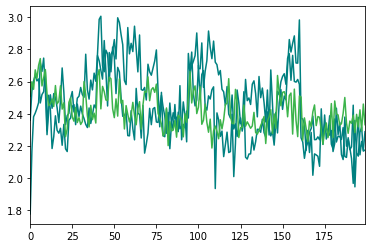

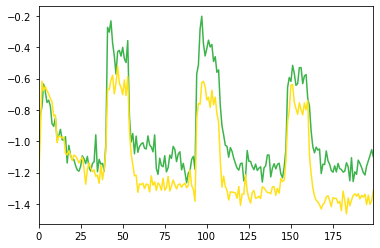

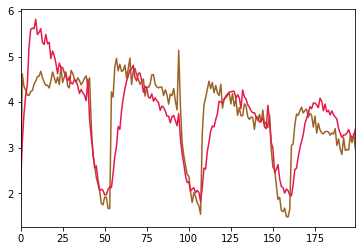

In [29]:
for clas in range(21):
    ind = []
    color = []
    for j in range(len(dlabels)):
        if (clas == dlabels[j]):
            ind.append(j)
            color.append(lots_of_colors[n_class[j]])
    row = n.iloc[ind]
    row.T.plot(legend=False, color=color)

In [22]:
row

0         1         2         3         4         5    \
Flash_40_wave_2   0.571081  0.494429  0.751718  0.580546  0.632446  0.855266   
Flash_40_wave_5   0.578530  1.201865  1.635306  1.709711  1.883825  1.952654   
Flash_40_wave_9   1.008382  2.477471  3.017654  3.341281  3.354314  3.384734   
Flash_40_wave_10  0.248530  0.416953  0.455576  0.699187  1.036392  1.096350   
Flash_40_wave_12  0.725933  1.218357  1.668949  1.720131  1.790919  1.817579   
...                    ...       ...       ...       ...       ...       ...   
Flash_46_wave_20 -0.230617  0.242136  0.243678  0.097646 -0.059439 -0.160777   
Flash_46_wave_49  0.489664  0.776835  0.748151  0.701139  0.610823  0.403806   
Flash_46_wave_65  2.334159  2.937608  2.372215  2.007245  1.645733  1.116064   
Flash_46_wave_86  0.569609  1.132857  1.210412  1.188244  1.100053  1.046596   
Flash_46_wave_94 -0.372969 -0.393594  0.042007 -0.065661 -0.007022 -0.026779   

                       6         7         8         9    ...       190  \
Flash_40_wave_2   0.680370  0.764025  0.453674  0.620698  ...  0.516698   
Flash_40_wave_5   1.961918  2.008558  1.999788  2.141422  ...  1.150016   
Flash_40_wave_9   3.659584  3.440983  3.091722  3.133273  ...  1.541847   
Flash_40_wave_10  1.453298  1.578031  1.419561  1.810905  ...  0.830766   
Flash_40_wave_12  1.877883  1.903725  2.120668  2.096569  ...  1.307997   
...                    ...       ...       ...       ...  ...       ...   
Flash_46_wave_20 -0.301872 -0.374978 -0.221080 -0.129753  ... -0.122369   
Flash_46_wave_49  0.305998  0.334984  0.448120  0.721728  ...  0.907489   
Flash_46_wave_65  0.814676  1.469086  1.106885  1.502549  ...  0.952743   
Flash_46_wave_86  0.846080  0.704067  0.861538  0.743415  ...  0.876272   
Flash_46_wave_94 -0.182787 -0.428858 -0.207789 -0.179428  ... -0.550326   

                       191       192       193       194       195       196  \
Flash_40_wave_2   0.785411  0.556864  0.525525  0.621531  0.685788  0.578357   
Flash_40_wave_5   0.960056  1.104510  0.978815  0.958205  0.997115  1.030643   
Flash_40_wave_9   1.488642  1.570359  1.386306  1.227205  1.396482  1.365136   
Flash_40_wave_10  0.904051  0.978478  1.184635  0.818035  1.053866  1.030528   
Flash_40_wave_12  1.306820  1.333423  1.306461  1.231195  1.261078  1.204456   
...                    ...       ...       ...       ...       ...       ...   
Flash_46_wave_20 -0.166195 -0.067828 -0.111783 -0.069593 -0.169309 -0.056324   
Flash_46_wave_49  0.802792  0.960652  0.962611  0.999189  0.796147  1.023783   
Flash_46_wave_65  0.747290  0.905035  0.744348  0.933812  0.672914  0.545547   
Flash_46_wave_86  1.013606  1.181771  1.193820  0.839227  0.850917  0.906549   
Flash_46_wave_94 -0.428076 -0.298865 -0.432138 -0.396407 -0.661898 -0.674112   

                       197       198       199  
Flash_40_wave_2   0.565160  0.614412  0.469929  
Flash_40_wave_5   1.107826  0.940766  1.002950  
Flash_40_wave_9   1.349914  1.402195  1.510781  
Flash_40_wave_10  1.075690  0.966558  1.039951  
Flash_40_wave_12  1.118920  1.399496  1.209888  
...                    ...       ...       ...  
Flash_46_wave_20 -0.114783  0.056633  0.002630  
Flash_46_wave_49  1.015788  1.010879  1.156180  
Flash_46_wave_65  0.528410  0.571942  0.361723  
Flash_46_wave_86  0.899229  1.125085  1.173561  
Flash_46_wave_94 -0.378286 -0.261541 -0.623124  

[423 rows x 200 columns]